In [1]:
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import random
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/tmp/ipykernel_37427/3831688300.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train_labels = pd.read_csv('./data/train_labels_5s.csv', index_col = [0,1,2])
val_labels = pd.read_csv('./data/val_labels_5s.csv', index_col = [0,1,2])
val_labels.head()

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                             False   
                                                   5.0        10.0                            False   
                                                   10.0       15.0                            False   
                                                   15.0       20.0                            False   
                                                   20.0       25.0                            False   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          False   
                                                   5.0        10.0                         False   
                                                   10.0       15.0                         False   
                                                   15.0       20.0                         False   
                                                   20.0       25.0                         False   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                  False   
                                                   5.0        10.0                 False   
                                                   10.0       15.0                 False   
                                                   15.0       20.0                 False   
                                                   20.0       25.0                 False   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                     False   
                                                   5.0        10.0                    False   
                                                   10.0       15.0                    False   
                                                   15.0       20.0                    False   
                                                   20.0       25.0                    False   

                                                                        Coua_caerulea  \
file                                               start_time end_time                  
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0               False   
                                                   5.0        10.0              False   
                                                   10.0       15.0              False   
                                                   15.0       20.0              False   
                                                   20.0       25.0              False   

                                                                        Zosterops_maderaspatanus  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          False   
                                                   5.0        10.0                         False   
                                                   10.0       15.0                         False   
                                                   15.0       20.0                         False   
                                                   20.0       25.0                         False   

             

In [3]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']


In [8]:
import torch

_original_torch_load = torch.load

def patched_load(*args, **kwargs):
    if "weights_only" not in kwargs:
        kwargs["weights_only"] = False
    return _original_torch_load(*args, **kwargs)

torch.load = patched_load


In [9]:
from bioacoustics_model_zoo import Perch

In [10]:
#specify the name of the file you want to load
filename = 'Shallow_classifier_perch_resample_formac'

In [11]:
perch_model = Perch.load(f'/mnt/class_data/group1_bioacoustics/sheila/Perch/{filename}.model')

2025-07-04 20:23:05.437273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-04 20:23:05.456005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-04 20:23:05.456044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-04 20:23:05.470289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-04 20:23:06.385232: W tensorflow/compiler/tf

In [12]:
perch_model.use_custom_classifier

True

In [13]:
# make predictions by passing the embeddings through the classifier
preds = perch_model.predict(val_labels,batch_size=64)

preds

  0%|          | 0/24 [00:00<?, ?it/s]

I0000 00:00:1751660628.897051   37427 service.cc:145] XLA service 0x5330ee30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751660628.897116   37427 service.cc:153]   StreamExecutor device (0): Host, Default Version
2025-07-04 20:23:49.120660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1751660629.128974   37427 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1751660631.481300   37427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1751661098.549116   37427 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          1.174817   
                                                   5.0        10.0                        -0.156153   
                                                   10.0       15.0                         0.092099   
                                                   15.0       20.0                        -0.675620   
                                                   20.0       25.0                        -1.037821   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                        -1.396700   
                                                   40.0       45.0                        -1.672088   
                                                   45.0       50.0                        -1.633366   
                                                   50.0       55.0                        -2.464486   
                                                   55.0       60.0                        -0.660092   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                      -3.609315   
                                                   5.0        10.0                     -4.768945   
                                                   10.0       15.0                     -5.052356   
                                                   15.0       20.0                     -1.855447   
                                                   20.0       25.0                     -4.232882   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                     -4.281525   
                                                   40.0       45.0                     -4.655500   
                                                   45.0       50.0                     -2.890872   
                                                   50.0       55.0                     -4.738090   
                                                   55.0       60.0                     -3.426065   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0              -3.652678   
                                                   5.0        10.0             -2.844096   
                                                   10.0       15.0             -3.121160   
                                                   15.0       20.0             -3.478835   
                                                   20.0       25.0             -2.424274   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0             -4.304942   
                                                   40.0       45.0             -5.207359   
                                                   45.0       50.0             -4.470904   
                                                   50.0       55.0             -5.416148   
                                                   55.0       60.0             -4.973526   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7101: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7102: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC

array([0.92959834, 0.9892258 , 0.98994597, 0.99252172, 0.99233188,
       0.99203635, 0.99931741, 0.98676671, 0.99965753, 0.99337636,
       0.98715482,        nan,        nan, 0.828019  , 0.99728445,
       0.63711761, 0.94931787,        nan, 0.89423729])

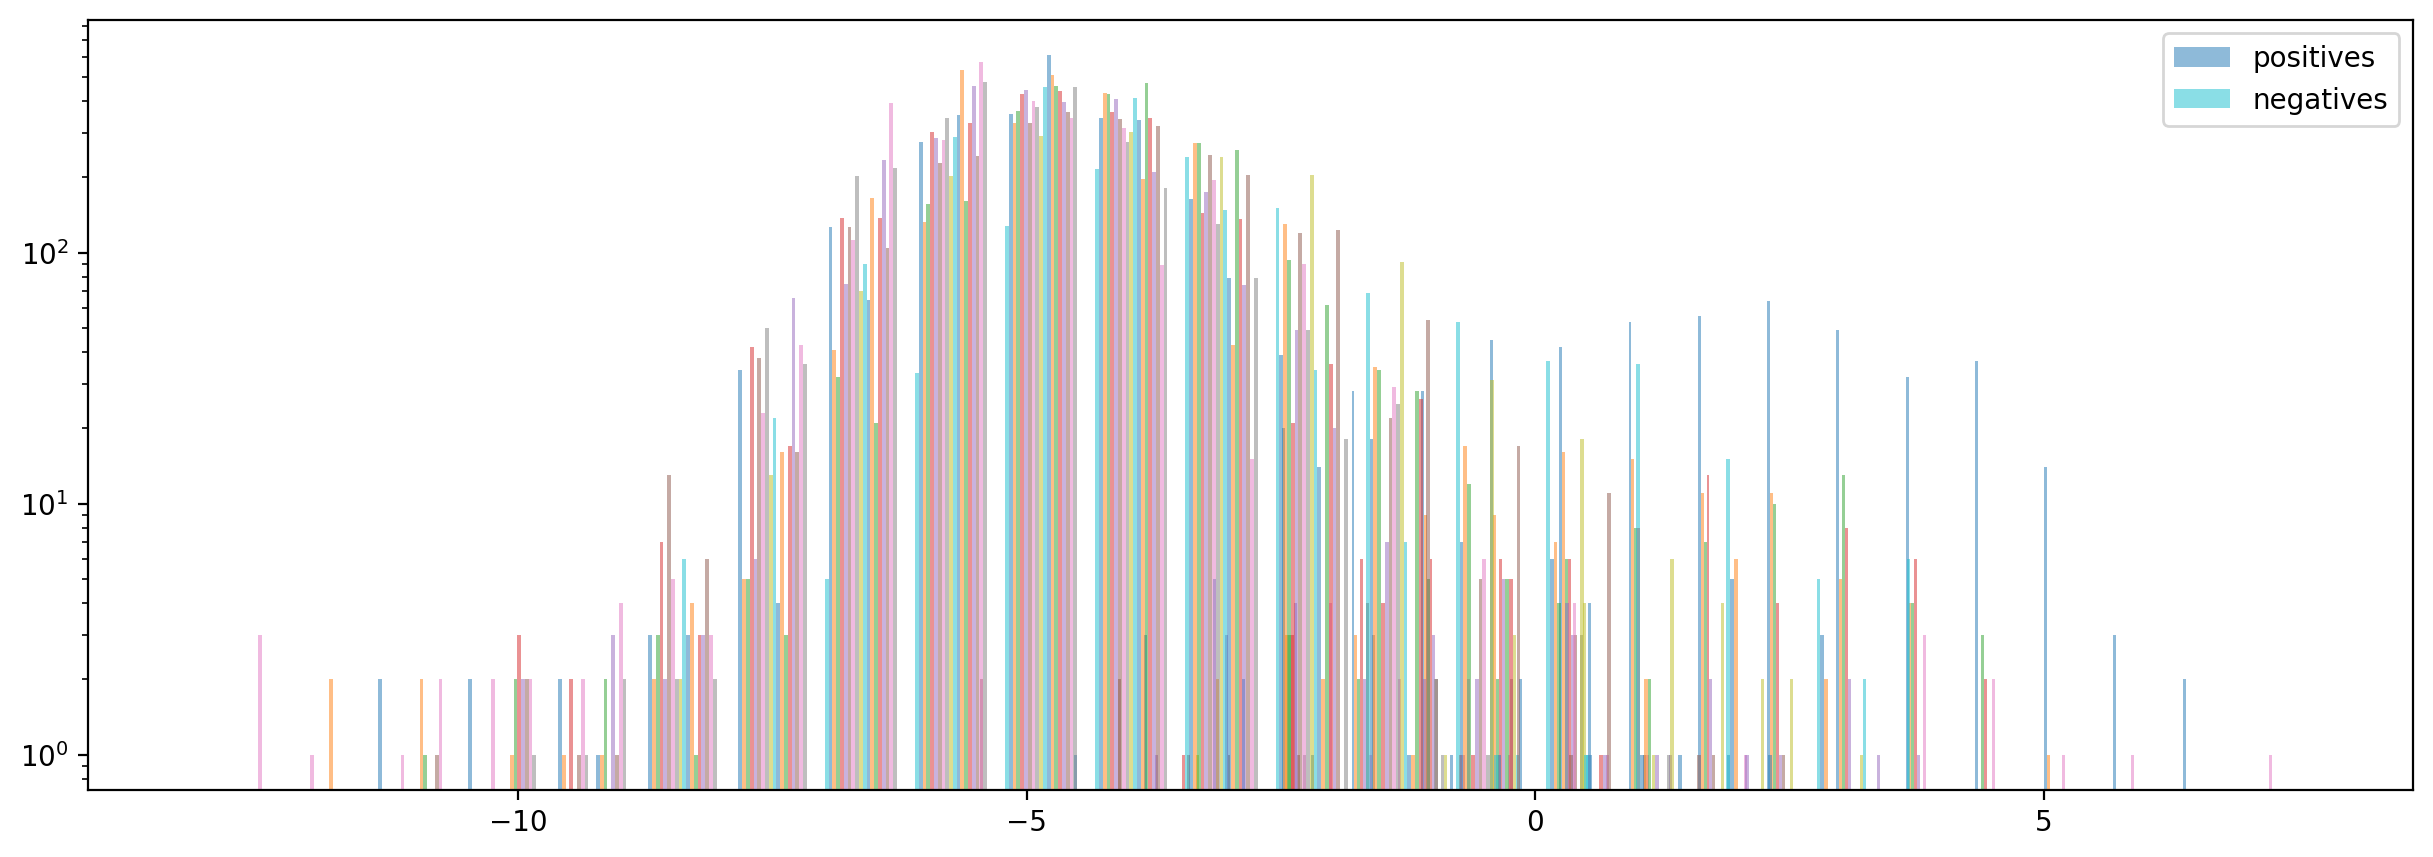

In [14]:

# plot histogram of scores for positive and negative clips
plt.hist(preds[val_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[val_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()
plt.semilogy()

# calculate the area under the ROC score
roc_auc_score(val_labels.values,preds,average=None)

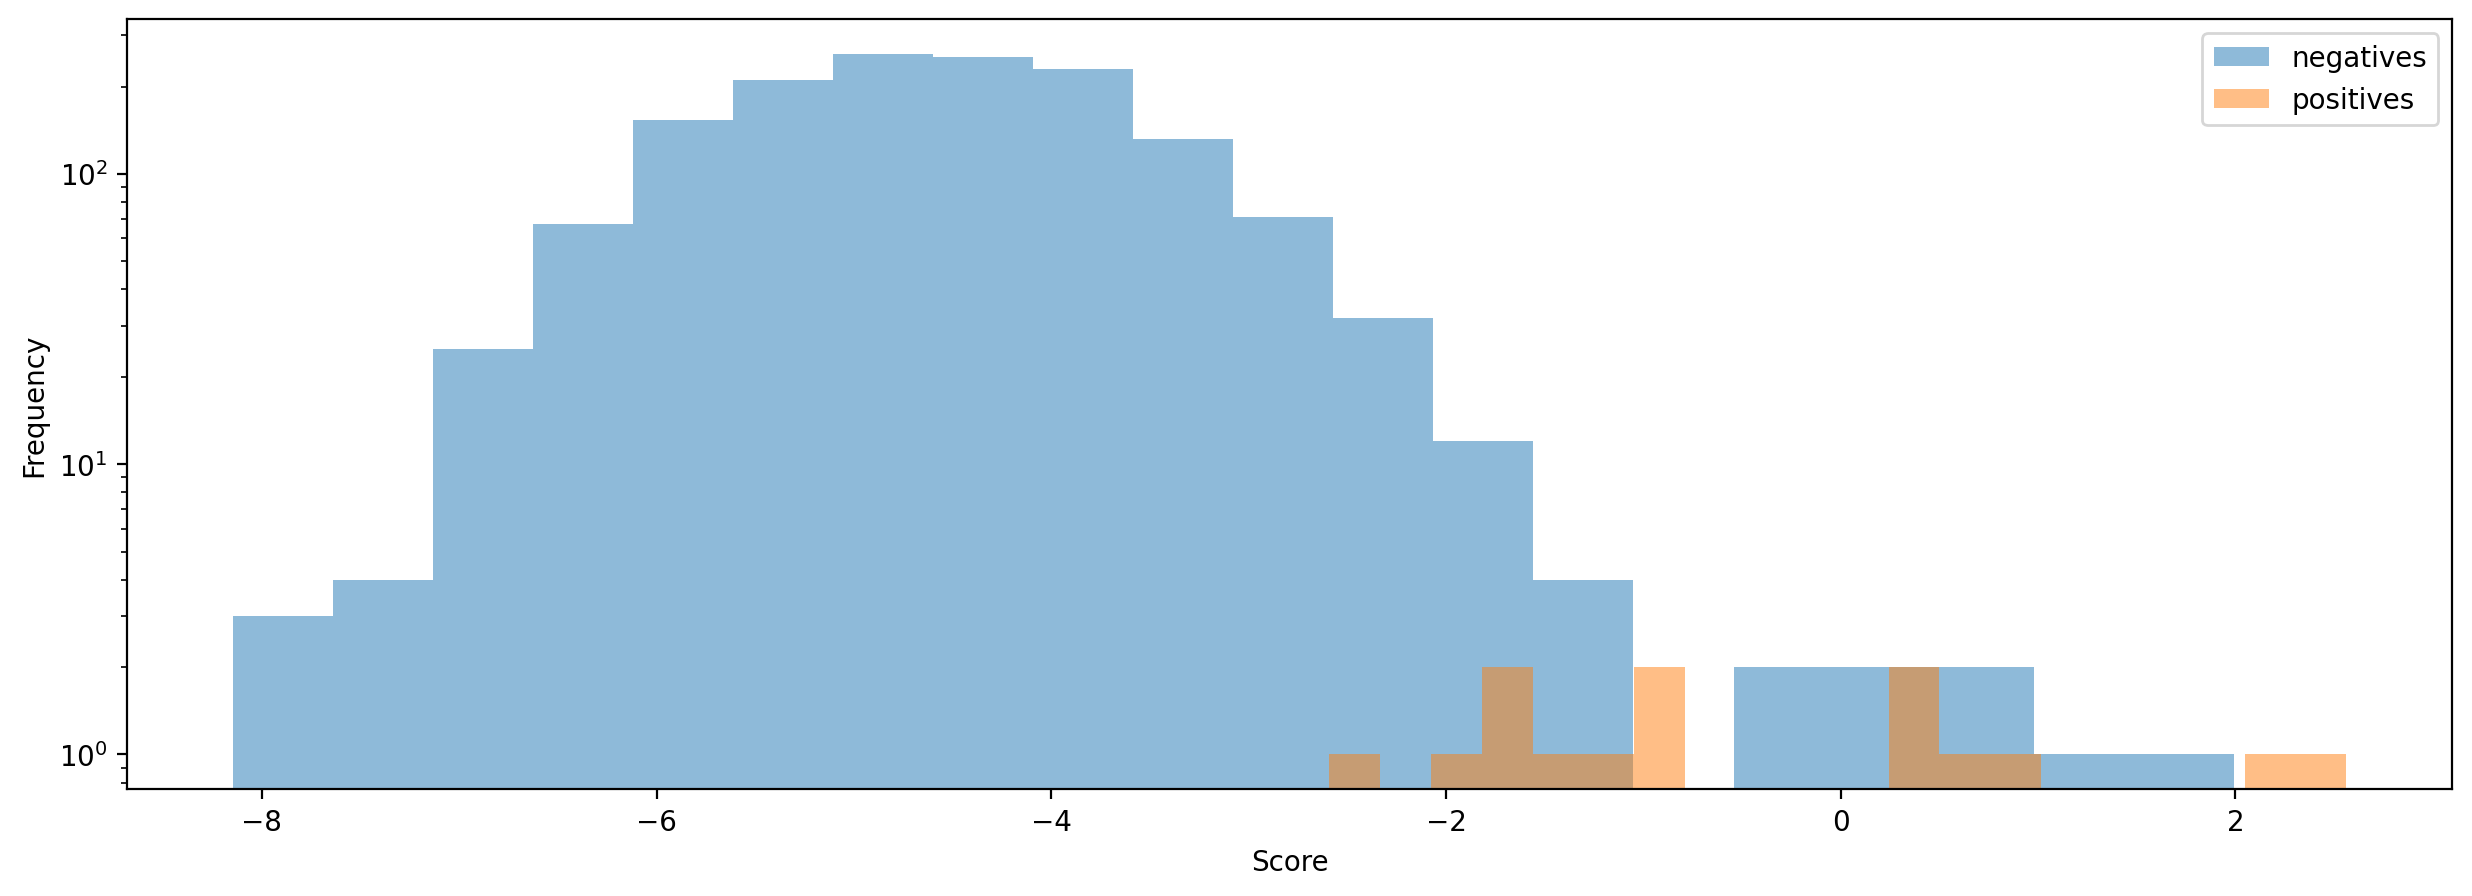

In [15]:
histspecies = 'Zosterops_maderaspatanus'
# Filter
df_Pos = preds[val_labels==True]
df_NOT = preds[val_labels==False]
# Plot histograms
plt.hist(df_NOT[histspecies],bins=20,alpha=0.5,label='negatives')
plt.hist(df_Pos[histspecies],bins=20,alpha=0.5,label='positives')
# Add a legend and labels
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.semilogy()
# Show the plot
plt.show()

In [16]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'
#write a loop to cycle through the class list and save histograms for each species for the model read in at the top of this notebook
path = '/mnt/class_data/group1_bioacoustics/sheila/histograms'
for species in class_list:
    speciespred = species + 'pred'
    scores_valid_df = val_labels.join(preds, rsuffix="pred")
    # Filter
    df_Pos = scores_valid_df[scores_valid_df[species] == True] #or whatever your class of interest is called
    df_NOT = scores_valid_df[scores_valid_df[species] == False]
    # Plot histograms
    plt.hist(df_NOT[speciespred],bins=20,alpha=0.5,label='negatives')
    plt.hist(df_Pos[speciespred],bins=20,alpha=0.5,label='positives')
    # Add a legend and labels
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    # Show the plot
    plt.savefig(f'/mnt/class_data/group1_bioacoustics/sheila/histograms/{filename}_{species}.png')
    plt.clf()

<Figure size 1500x500 with 0 Axes>

In [17]:
#set up plotting on log scale on y axis - easier to see small sample sizes
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'
#write a loop to cycle through the class list and save histograms for each species for the model read in at the top of this notebook
path = '/mnt/class_data/group1_bioacoustics/sheila/histograms'
for species in class_list:
    speciespred = species + 'pred'
    scores_valid_df = val_labels.join(preds, rsuffix="pred")
    # Filter
    df_Pos = scores_valid_df[scores_valid_df[species] == True] #or whatever your class of interest is called
    df_NOT = scores_valid_df[scores_valid_df[species] == False]
    # Plot histograms
    plt.hist(df_NOT[speciespred],bins=20,alpha=0.5,label='negatives')
    plt.hist(df_Pos[speciespred],bins=20,alpha=0.5,label='positives')
    # Add a legend and labels
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.semilogy()
    # Save the plot
    plt.savefig(f'/mnt/class_data/group1_bioacoustics/sheila/histograms/semilog/{filename}_{species}.png')
    plt.clf()

<Figure size 1500x500 with 0 Axes>

In [18]:
avprecscore_auroc_by_sp = pd.DataFrame(columns=['species', 'avg_precision_score','auroc_score'])
for species in class_list:
    avgscore = sklearn.metrics.average_precision_score(val_labels [species],preds [species])
    auroc = sklearn.metrics.roc_auc_score(val_labels[species],preds [species])
    new_row = pd.DataFrame({'species': [species], 'avg_precision_score': [avgscore], 'auroc_score': [auroc]})
    avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)

avprecscore_auroc_by_sp

/tmp/ipykernel_37427/3174497413.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/tf2_16/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, reca

,species,avg_precision_score,auroc_score
0,Hypsipetes_madagascariensis,0.858055,0.929598
1,Copsychus_albospecularis,0.793880,0.989226
2,Coracopsis_nigra,0.825110,0.989946
3,Dicrurus_forficatus,0.896866,0.992522
4,Coua_caerulea,0.831603,0.992332
5,Zosterops_maderaspatanus,0.543410,0.992036
6,Eurystomus_glaucurus,0.943939,0.999317
7,Agapornis_canus,0.533494,0.986767
8,Saxicola_torquatus,0.961838,0.999658
9,Cyanolanius_madagascarinus,0.576511,0.993376


In [19]:
avprecscore_auroc_by_sp.to_csv(f'/mnt/class_data/group1_bioacoustics/sheila/results/{filename}.csv')